In [2]:
import sys

sys.path.append("..")

from tools.tools import (
    get_ts_data_for_graph,
    load_sample,
    graph_to_label_tensor,
    score
)
from tools.display_tools import plot_current_state_of_graph,simple_sample_display
from tools.baseline_methods import cross_correlation_for_causal_discovery, var_baseline
import pickle
import pandas as pd
import numpy as np
from IPython.display import HTML
from hydra import initialize, compose
import matplotlib.pyplot as plt
import networkx as nx
from datetime import date, timedelta, datetime
from statsmodels.tsa.api import VAR


### Unfinished tutorial for using model fit for ts subselection

In [2]:
%load_ext autoreload
%autoreload 2

### Dataset usage tutorial

In [19]:
# To keep everything clean we use hydra for HPs.
with initialize(version_base=None, config_path="config/"):
    cfg = compose(config_name='predict_single.yaml')

In [21]:
G = pickle.load(open("resources/rivers_east_germany.p", "rb"))

In [22]:
stats = [G.nodes[x]["origin"] for x in G.nodes]

In [23]:
pd.DataFrame(stats).value_counts()

T       175
S       167
BR      145
SA       92
MV       67
BSCV     12
B         8
dtype: int64

## Scoring a sample

In [20]:
# Load the raw ts data and the labels for a specific sample:

ds  =pickle.load(open(cfg.sample_path + "random_3" + "/test.p", "rb"))
example = ds[4]
data = load_sample(p= cfg.data_path, which= example)


In [16]:
#data = pd.read_csv("resources/rivers_ts_bavaria.csv", index_col=0)
data = pd.read_csv("resources/rivers_ts_east_germany.csv", index_col=0)

In [17]:
missing = data.isnull().sum() / len(data)

In [20]:
missing.mean()

0.0815575467307395

In [14]:
len(data.columns)

494

In [19]:
(missing < 0.05).sum() / len(data.columns)

0.7012012012012012

In [8]:
missing.mean()

NameError: name 'missing' is not defined

In [94]:
# Run some standard preprocessing steps
sample_data = get_ts_data_for_graph(
    data,
    resolution=cfg.resolution_value,
    interpolate=True,
    normalize=True,
)

<Axes: xlabel='datetime'>

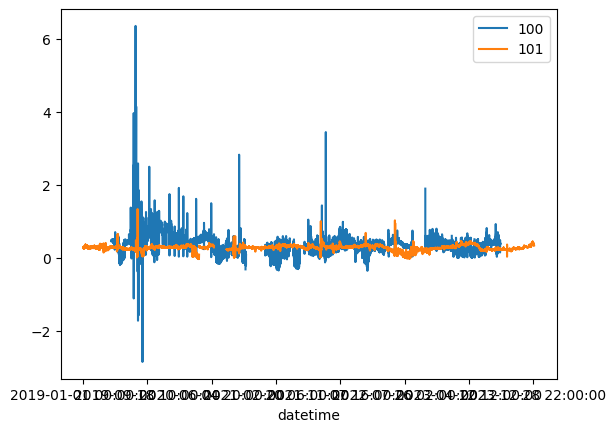

In [96]:
data

In [90]:
var_baseline(sample_data,cfg.method_hps)

/home/stein/anaconda3/envs/rivers1k/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


array([[1.06069082, 0.37516572],
       [0.176305  , 1.40667192]])

In [92]:
var_baseline(sample_data[42*720:43*720],cfg.method_hps)

/home/stein/anaconda3/envs/rivers1k/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


array([[0.82955691, 0.86675909],
       [0.57125257, 1.6264544 ]])

In [45]:
check_trailing_nans = np.where(sample_data.isnull().values.any(axis=1) == 0)[0]
sample_data = sample_data[check_trailing_nans.min() : check_trailing_nans.max()+1]

In [55]:
sample_data



res = VAR(sample_data.values).fit(maxlags=3)

In [59]:
resids = []
for x in range (0,len(sample_data), 720):
    resids.append(VAR(sample_data.values[x:x+720]).fit(maxlags=3).resid)

In [68]:
errors = [np.absolute(x).mean() for x in resids]

In [71]:
np.argmin(errors)

41

In [85]:
graph_to_label_tensor(example, human_readable=True)

Cause     
             444  445
Effect 444   0.0  1.0
       445   0.0  0.0

In [74]:



res = VAR(sample_data.values[42*720:43*720]).fit(maxlags=3)

In [82]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Sep, 2024
Time:                     13:50:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.4482
Nobs:                     717.000    HQIC:                  -22.5030
Log likelihood:           6058.95    FPE:                1.62958e-10
AIC:                     -22.5375    Det(Omega_mle):     1.59822e-10
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000947         0.000192            4.923           0.000
L1.y1         0.971699         0.029675           32.744           0.000
L1.y2         0.832339         0.027906           29.827           0.000
L2.y1        -0.140538

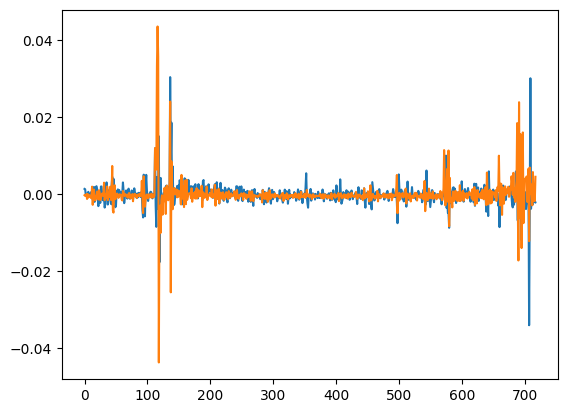

In [80]:
plt.plot(res.resid)

<Axes: xlabel='dt'>

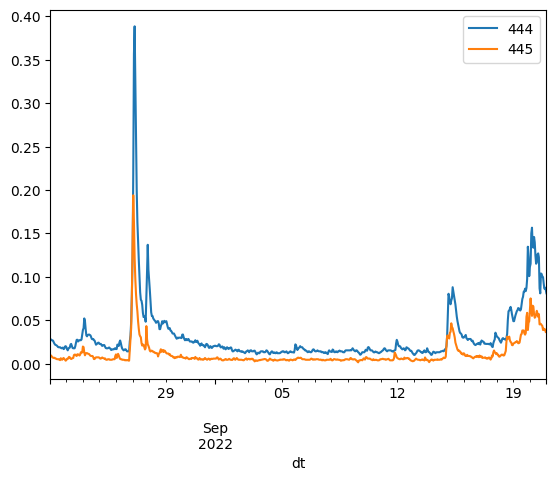

In [73]:
sample_data[42*720:43*720].plot()

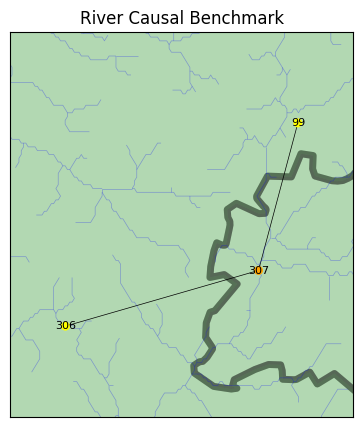

In [30]:
# Single Sample plotting works in the same way.
plot_current_state_of_graph(
    example,
    dpi=100,
    autozoom=0.1,
    lim=(50.1, 54.8),
    limx=(9.65, 15.1),
    node_size=30,
    save=0,
    river_map=1,
    ger_map=1,
    width=0.5,
    arrowsize=0.5,
    fs=(5, 5),
    font_size=8,
)

In [61]:
# labels can be exported from graph like this:
label = graph_to_label_tensor(example, human_readable=True)
label

Cause          
             307  306  99 
Effect 307   0.0  0.0  1.0
       306   1.0  0.0  0.0
       99    0.0  0.0  0.0

In [32]:
# Run some standard preprocessing steps
sample_data = get_ts_data_for_graph(
    data,
    resolution=cfg.resolution_value,
    interpolate=cfg.interpolation,
    normalize=cfg.normalize,
)

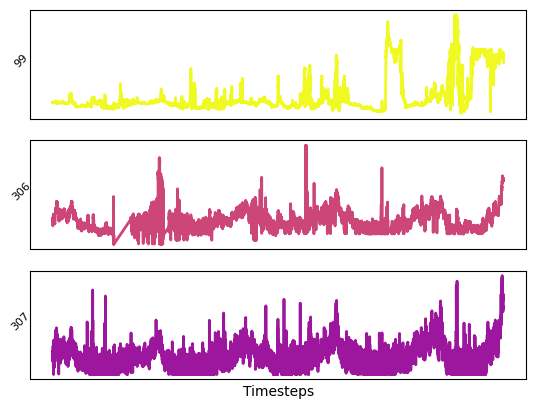

In [33]:
simple_sample_display(sample_data)

In [45]:
res = cross_correlation_for_causal_discovery(sample_data,cfg.method_hps, human_readable=True)
res 

Cause              
               99    306    307
Effect 99   False  False  False
       306   True  False   True
       307   True  False  False

In [62]:
# Score expect a set of samples so we expand here.

score(np.expand_dims(res.values,0),np.expand_dims(label.values,0),cfg)

Scoring...


,corr_debug_set_3
Metric,
Best Acc thresh,1.0
Best Acc,0.666667
Null Acc,0.666667
Best F1 thresh,False
Best F1,0.5
Null F1,0.5
AUROC,0.5
